# STL-10 Dataset

In [2]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import os
import urllib.request as urllib
import tarfile
import sys

import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K, regularizers
from keras.callbacks import LearningRateScheduler
from keras.engine.training import Model
from keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, Input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from vis.visualization import visualize_cam
import matplotlib.cm as cm
# the dimensions of each image in the STL-10 dataset (96x96x3).
HEIGHT, WIDTH, DEPTH = 96, 96, 3

# number of classes in the STL-10 dataset.
N_CLASSES = 10

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './stl10_data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
TRAIN_DATA_PATH = DATA_DIR + '/stl10_binary/train_X.bin'

# path to the binary test file with image data
TEST_DATA_PATH = DATA_DIR + '/stl10_binary/test_X.bin'

# path to the binary train file with labels
TRAIN_LABELS_PATH = DATA_DIR + '/stl10_binary/train_y.bin'

# path to the binary test file with labels
TEST_LABELS_PATH = DATA_DIR + '/stl10_binary/test_y.bin'

# path to class names file
CLASS_NAMES_PATH = DATA_DIR + '/stl10_binary/class_names.txt'

def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, DEPTH, WIDTH, HEIGHT))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def download_and_extract():
    # if the dataset already exists locally, no need to download it again.
    if all((
        os.path.exists(TRAIN_DATA_PATH),
        os.path.exists(TRAIN_LABELS_PATH),
        os.path.exists(TEST_DATA_PATH),
        os.path.exists(TEST_LABELS_PATH),
    )):
        return

    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
        
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                                                          float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()

        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)


def load_dataset():
    # download the extract the dataset.
    download_and_extract()

    # load the train and test data and labels.
    x_train = read_all_images(TRAIN_DATA_PATH)
    y_train = read_labels(TRAIN_LABELS_PATH)
    x_test = read_all_images(TEST_DATA_PATH)
    y_test = read_labels(TEST_LABELS_PATH)

    # convert all images to floats in the range [0, 1]
    x_train = x_train.astype('float32')
    x_train = (x_train - 127.5) / 127.5
    x_test = x_test.astype('float32')
    x_test = (x_test - 127.5) / 127.5
    
    # convert the labels to be zero based.
    y_train -= 1
    y_test -= 1

    # convert labels to hot-one vectors.
    y_train = keras.utils.to_categorical(y_train, N_CLASSES)
    y_test = keras.utils.to_categorical(y_test, N_CLASSES)
    x_train -= np.mean(x_train, axis = 0)
    x_test -= np.mean(x_test, axis = 0)
    
    
    return (x_train, y_train), (x_test, y_test)

(x_test, y_test) , (x_train, y_train)= load_dataset()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, random_state=5)




(8000, 96, 96, 3) (8000, 10) (5000, 96, 96, 3) (5000, 10)


# Data augmentation
Data augmentation using MixupGenerator and ImageDataGenerator

In [3]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y    
    
datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
   
   )
training_generator = MixupGenerator(x_train, y_train, batch_size=128, alpha=0.5, datagen=datagen)()



# CNN Model

In [6]:

def build_classifier_model():
    n_conv_blocks = 4  # number of convolution blocks to have in our model.
    n_filters = 16 # number of filters to use in the first convolution block.
    l2_reg = regularizers.l2(2e-4)  # weight to use for L2 weight decay. 
    activation = 'elu'  # the activation function to use after each linear operation.

    if K.image_data_format() == 'channels_first':
        input_shape = (3, HEIGHT, WIDTH)
    else:
        input_shape = (HEIGHT, WIDTH, 3)

    x = input_1 = Input(shape=input_shape)
    
    # each convolution block consists of two sub-blocks of Conv->Batch-Normalization- bn>Activation,
    # followed by a Max-Pooling and a Dropout layer.
    for i in range(n_conv_blocks):
        shortcut = Conv2D(filters=n_filters, kernel_size=(1, 1), padding='same', kernel_regularizer=l2_reg)(x)
        x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = BatchNormalization()(x)
        x = Activation(activation=activation)(x)
        
        x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = Add()([shortcut, x])
        x = BatchNormalization()(x)
        x = Activation(activation=activation)(x)
        
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(rate=0.25)(x)
        
        n_filters *= 2

    # finally, we flatten the output of the last convolution block, and add two Fully-Connected layers.
    x = Flatten()(x)
    x = Dense(units=512, kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Activation(activation=activation)(x)

    x = Dropout(rate=0.5)(x)
    x = Dense(units=N_CLASSES, kernel_regularizer=l2_reg)(x)
    output = Activation(activation='softmax')(x)

    return Model(inputs=[input_1], outputs=[output])


model = build_classifier_model()
model.summary()  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 96, 96, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 96, 96, 16)   64          conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 96, 96, 16)   0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
conv2d_13 

# Learning rate scheduling & Model fit

In [8]:
def train_classifier(model_output_path=None, batch_size=128, epochs = 200, initial_lr=1e-3):    
    def lr_scheduler(epoch):
        if epoch < 40:
            return initial_lr
        elif epoch < 80:
            return initial_lr / 2
        elif epoch < 120:
            return initial_lr / 4
        elif epoch < 160:
            return initial_lr / 8
        elif epoch < 180:
            return initial_lr / 16     
        else:
            return initial_lr / 32

    model.compile( 
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(initial_lr),
        metrics=['accuracy']
    )

    history = model.fit_generator(
    generator=training_generator,
    steps_per_epoch = int(np.ceil(x_train.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(x_val, y_val),
    callbacks=[LearningRateScheduler(lr_scheduler)]
)
  

    if model_output_path is not None:
        print('saving trained model to:', model_output_path)
        model.save(model_output_path)
        
    return history


history = train_classifier()


Epoch 1/200
63/63 [==============================] - 20s 312ms/step - loss: 2.2336 - acc: 0.3909 - val_loss: 1.8503 - val_acc: 0.4810
Epoch 2/200
63/63 [==============================] - 18s 287ms/step - loss: 2.0771 - acc: 0.4387 - val_loss: 1.5474 - val_acc: 0.5530
Epoch 3/200
63/63 [==============================] - 19s 298ms/step - loss: 1.9846 - acc: 0.4778 - val_loss: 1.4599 - val_acc: 0.5860
Epoch 4/200
63/63 [==============================] - 19s 309ms/step - loss: 1.9011 - acc: 0.5148 - val_loss: 1.4633 - val_acc: 0.5840
Epoch 5/200
63/63 [==============================] - 19s 308ms/step - loss: 1.8459 - acc: 0.5212 - val_loss: 1.3858 - val_acc: 0.6110
Epoch 6/200
63/63 [==============================] - 19s 308ms/step - loss: 1.8149 - acc: 0.5402 - val_loss: 1.3441 - val_acc: 0.6200
Epoch 7/200
63/63 [==============================] - 19s 306ms/step - loss: 1.7416 - acc: 0.5678 - val_loss: 1.3649 - val_acc: 0.5980
Epoch 8/200
63/63 [==============================] - 19s 306ms

Epoch 62/200
63/63 [==============================] - 18s 291ms/step - loss: 1.2570 - acc: 0.7433 - val_loss: 0.7875 - val_acc: 0.7890
Epoch 63/200
63/63 [==============================] - 19s 297ms/step - loss: 1.2390 - acc: 0.7521 - val_loss: 0.8346 - val_acc: 0.7700
Epoch 64/200
63/63 [==============================] - 19s 297ms/step - loss: 1.2460 - acc: 0.7439 - val_loss: 0.8332 - val_acc: 0.7780
Epoch 65/200
63/63 [==============================] - 19s 300ms/step - loss: 1.2412 - acc: 0.7474 - val_loss: 0.8340 - val_acc: 0.7800
Epoch 66/200
63/63 [==============================] - 19s 295ms/step - loss: 1.2588 - acc: 0.7432 - val_loss: 0.8400 - val_acc: 0.7770
Epoch 67/200
63/63 [==============================] - 19s 303ms/step - loss: 1.2377 - acc: 0.7514 - val_loss: 0.7903 - val_acc: 0.8010
Epoch 68/200
63/63 [==============================] - 19s 302ms/step - loss: 1.2528 - acc: 0.7459 - val_loss: 0.7439 - val_acc: 0.8120
Epoch 69/200
63/63 [==============================] - 1

63/63 [==============================] - 19s 301ms/step - loss: 1.0794 - acc: 0.8100 - val_loss: 0.6551 - val_acc: 0.8270
Epoch 123/200
63/63 [==============================] - 19s 295ms/step - loss: 1.0590 - acc: 0.8191 - val_loss: 0.6458 - val_acc: 0.8290
Epoch 124/200
63/63 [==============================] - 19s 298ms/step - loss: 1.0488 - acc: 0.8266 - val_loss: 0.6761 - val_acc: 0.8140
Epoch 125/200
63/63 [==============================] - 19s 297ms/step - loss: 1.0569 - acc: 0.8154 - val_loss: 0.6587 - val_acc: 0.8150
Epoch 126/200
63/63 [==============================] - 19s 308ms/step - loss: 1.0607 - acc: 0.8213 - val_loss: 0.6387 - val_acc: 0.8200
Epoch 127/200
63/63 [==============================] - 18s 291ms/step - loss: 1.0536 - acc: 0.8248 - val_loss: 0.6462 - val_acc: 0.8220
Epoch 128/200
63/63 [==============================] - 18s 291ms/step - loss: 1.0524 - acc: 0.8229 - val_loss: 0.6409 - val_acc: 0.8320
Epoch 129/200
63/63 [==============================] - 19s 294

63/63 [==============================] - 19s 299ms/step - loss: 0.9799 - acc: 0.8500 - val_loss: 0.6106 - val_acc: 0.8320
Epoch 183/200
63/63 [==============================] - 19s 297ms/step - loss: 0.9721 - acc: 0.8475 - val_loss: 0.6038 - val_acc: 0.8370
Epoch 184/200
63/63 [==============================] - 19s 296ms/step - loss: 0.9832 - acc: 0.8445 - val_loss: 0.6045 - val_acc: 0.8310
Epoch 185/200
63/63 [==============================] - 19s 296ms/step - loss: 0.9886 - acc: 0.8488 - val_loss: 0.6103 - val_acc: 0.8300
Epoch 186/200
63/63 [==============================] - 19s 298ms/step - loss: 0.9718 - acc: 0.8518 - val_loss: 0.6102 - val_acc: 0.8330
Epoch 187/200
63/63 [==============================] - 19s 299ms/step - loss: 0.9666 - acc: 0.8487 - val_loss: 0.6173 - val_acc: 0.8240
Epoch 188/200
63/63 [==============================] - 19s 299ms/step - loss: 0.9849 - acc: 0.8485 - val_loss: 0.6076 - val_acc: 0.8350
Epoch 189/200
63/63 [==============================] - 19s 299

# Training Score

In [9]:
score, acc = model.evaluate(x_test, y_test, verbose = 0)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.5384414726495743
Test accuracy: 0.85925


# Plot loss function, train-val accuracy

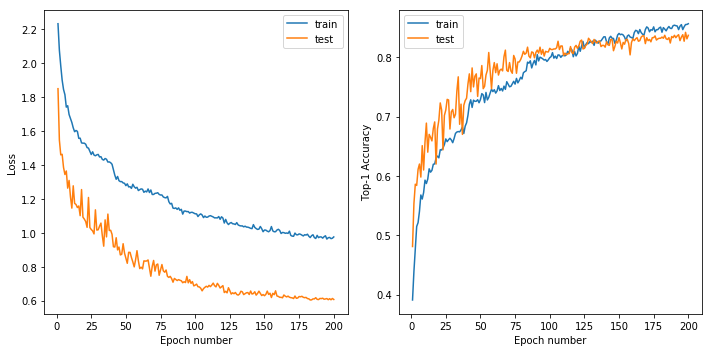

In [10]:
def plot_training_history(history):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].plot(np.arange(1, epochs + 1), loss, label='train')
    axs[0].plot(np.arange(1, epochs + 1), val_loss, label='test')
    axs[0].set_xlabel('Epoch number')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc="best")

    acc, val_acc = history.history['acc'], history.history['val_acc']
    axs[1].plot(np.arange(1, epochs + 1), acc, label='train')
    axs[1].plot(np.arange(1, epochs + 1), val_acc, label='test')
    axs[1].set_xlabel('Epoch number')
    axs[1].set_ylabel('Top-1 Accuracy')
    axs[1].legend(loc="best")
    
    plt.tight_layout()
    plt.show()
    
    
plot_training_history(history)
